In [1]:
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
import pymbar

from collections import namedtuple
%matplotlib inline

@jit
def perturbation(x):
    return 5 * x
    #return x * np.sin(10 * x)

@jit
def grad_perturbation(x):
    return 5
    #return np.sin(10 * x) + 10 * x * np.cos(10 * x)

@jit
def potential(x, lam):
    return x**4 + lam * perturbation(x)

@jit
def grad_potential(x, lam):
    return 4 * x**3 + lam * grad_perturbation(x)

@jit
def force(x, lam):
    return - grad_potential(x, lam)

gamma = 10.0
beta = 1.0
m = 10.0
velocity_scale = np.sqrt(1.0 / (beta * m))
dt = 0.5

@jit
def simulate_vvvr(x0, v0, lambdas):
    """Simulate VVVR with explicit hamiltonian updates,
    accumulating shadow work and protocol work"""
    n_steps = len(lambdas)
    W_prots = np.zeros(n_steps)
    W_shads = np.zeros(n_steps)
    
    x, v = x0, v0
    xs, vs = np.zeros(n_steps), np.zeros(n_steps)
    xs[0] = x0
    vs[0] = v0

    a = np.exp(- gamma * (dt / 2.0))
    b = np.sqrt(1 - np.exp(-2 * gamma * (dt / 2.0)))

    for i in range(1, n_steps):
        old_lambda = lambdas[i - 1]
        new_lambda = lambdas[i]

        # O step : heat (ignore)
        v = (a * v) + b * velocity_scale * np.random.randn()

        # half V step : shadow work
        ke_old = 0.5 * m * v**2
        v = v + ((dt / 2.0) * force(x, old_lambda) / m)
        ke_new = 0.5 * m * v ** 2
        W_shads[i] += (ke_new - ke_old)

        # half R step : shadow work
        pe_old = potential(x, old_lambda)
        x = x + ((dt/2.0) * v)
        pe_new = potential(x, old_lambda)
        W_shads[i] += (pe_new - pe_old)

        # update hamiltonian: protocol work
        W_prots[i] = potential(x, new_lambda) - potential(x, old_lambda)

        # half R step : shadow work
        pe_old = potential(x, new_lambda)
        x = x + ((dt/2.0) * v)
        pe_new = potential(x, new_lambda)
        W_shads[i] += (pe_new - pe_old)

        # half V step : shadow work
        ke_old = 0.5 * m * v**2
        v = v + ((dt / 2.0) * force(x, new_lambda) / m)
        ke_new = 0.5 * m * v ** 2
        W_shads[i] += (ke_new - ke_old)

        # O step : heat (ignore)
        v = (a * v) + b * velocity_scale * np.random.randn()
        
        xs[i] = x
        vs[i] = v
    
    return xs, vs, W_shads, W_prots


# draw samples from nonequilibrium steady state
discard = 1000
xs, vs, _, _ = simulate_vvvr(np.random.randn(), np.random.randn() * velocity_scale, np.zeros(10000000))
rho_x_0, rho_v_0 = xs[discard:], vs[discard:]

xs, vs, _, _ = simulate_vvvr(np.random.randn(), np.random.randn() * velocity_scale, np.ones(10000000))
rho_x_1, rho_v_1 = xs[discard:], vs[discard:]

# now, let's consider estimating the free energy difference from work measurements...

n_protocol_samples = 100000

def simulate_forward_protocol(protocol_length=100):
    """Apply forward protocol to initial conditions drawn from rho_0"""
    i = np.random.randint(len(rho_x_0))
    protocol = np.linspace(0, 1, protocol_length)
    return simulate_vvvr(rho_x_0[i], rho_v_0[i], protocol)

def simulate_reverse_protocol(protocol_length=100):
    """Apply reverse protocol to initial conditions drawn from rho_1"""
    i = np.random.randint(len(rho_x_1))
    protocol = np.linspace(1, 0, protocol_length)
    return simulate_vvvr(rho_x_1[i], rho_v_1[i], protocol)


Result = namedtuple("Result", ["forward_raw", "reverse_raw", "forward_corrected", "reverse_corrected"])

def collect_samples(protocol_length=100):
    # collect forward and reverse work values
    forward, reverse = np.zeros(n_protocol_samples), np.zeros(n_protocol_samples)
    forward_corrected, reverse_corrected = np.zeros(n_protocol_samples), np.zeros(n_protocol_samples)

    for i in tqdm(range(n_protocol_samples)):
        _, _, W_shads_F, W_prots_F = simulate_forward_protocol(protocol_length)
        _, _, W_shads_R, W_prots_R = simulate_reverse_protocol(protocol_length)

        forward[i]  = np.sum(W_prots_F)
        reverse[i] = np.sum(W_prots_R)

        forward_corrected[i]  = np.sum(W_prots_F) + np.sum(W_shads_F)
        reverse_corrected[i] = np.sum(W_prots_R) + np.sum(W_shads_R)
    
    result = Result(forward, reverse, forward_corrected, reverse_corrected)
    return result
    
protocol_lengths = [2, 10, 100, 1000, 10000]
results = []
for protocol_length in protocol_lengths:
    results.append(collect_samples(protocol_length))

100%|██████████| 100000/100000 [03:32<00:00, 471.56it/s]


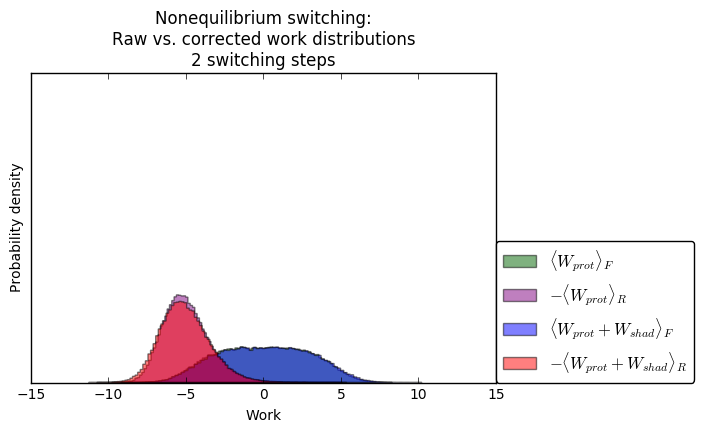

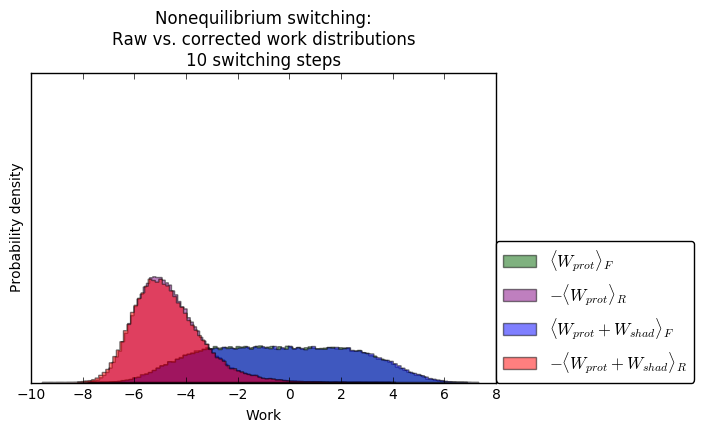

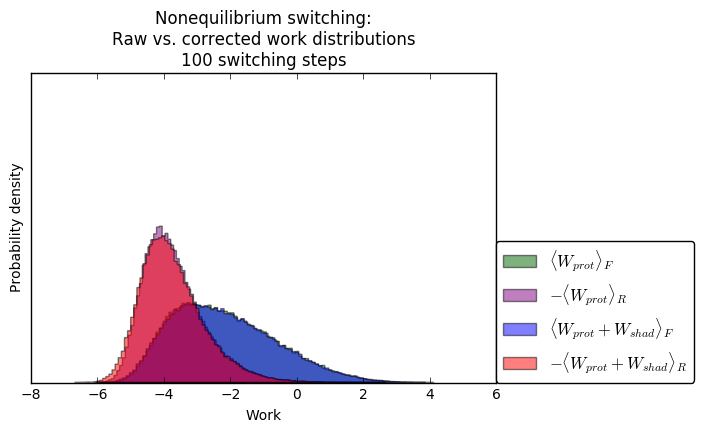

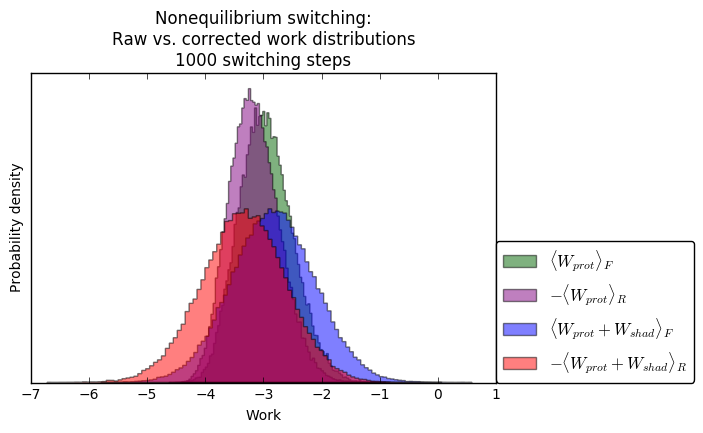

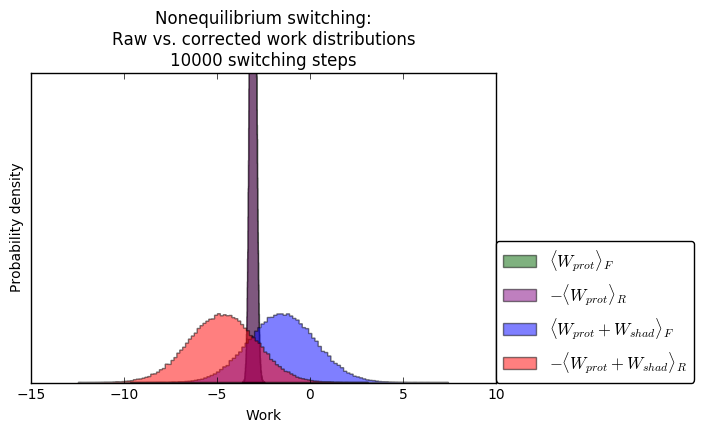

In [3]:
def plot_work_distributions(result):

    # Plot the forward and reverse protocol work
    hist_args = {"bins": 100, "alpha": 0.5, "histtype": "stepfilled", "normed": True}
    plt.hist(result.forward_raw, label=r"$\langle W_{prot} \rangle_F$", color="darkgreen", **hist_args);
    plt.hist(- result.reverse_raw, label=r"$- \langle W_{prot} \rangle_R$", color="purple", **hist_args);

    # Plot the forward and reverse protocol work + shadow work
    plt.hist(result.forward_corrected, label=r"$\langle W_{prot} + W_{shad} \rangle_F$", color="blue", **hist_args);
    plt.hist(- result.reverse_corrected, label=r"$- \langle W_{prot} + W_{shad} \rangle_R$", color="red", **hist_args);

    # Format
    plt.legend(loc=(1,0), fancybox=True)
    plt.title("Nonequilibrium switching:\nRaw vs. corrected work distributions")
    plt.xlabel("Work")
    plt.ylabel("Probability density")
    plt.yticks([])
    plt.ylim(0,1)
    
    
for i in range(len(protocol_lengths)):
    plt.figure()
    plot_work_distributions(results[i])
    plt.title("Nonequilibrium switching:\nRaw vs. corrected work distributions\n{} switching steps".format(
            protocol_lengths[i]))

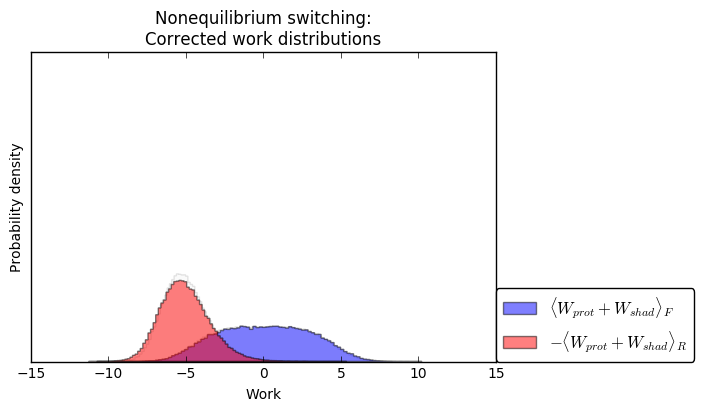

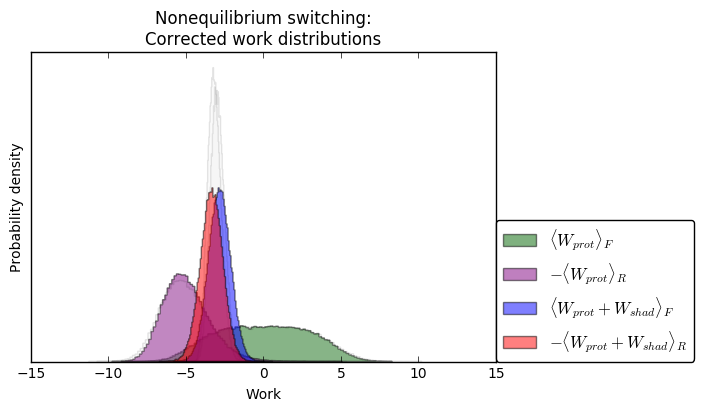

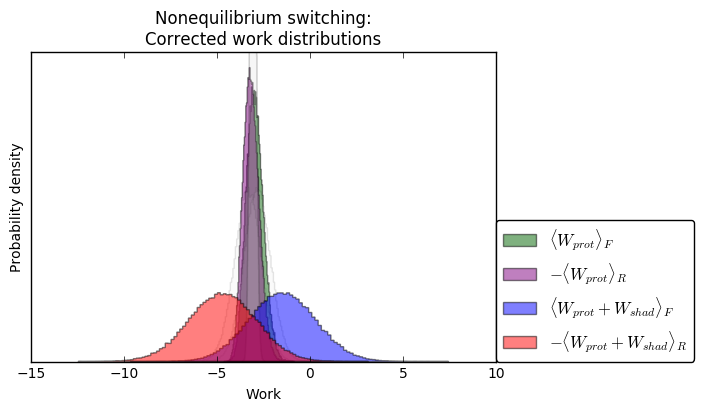

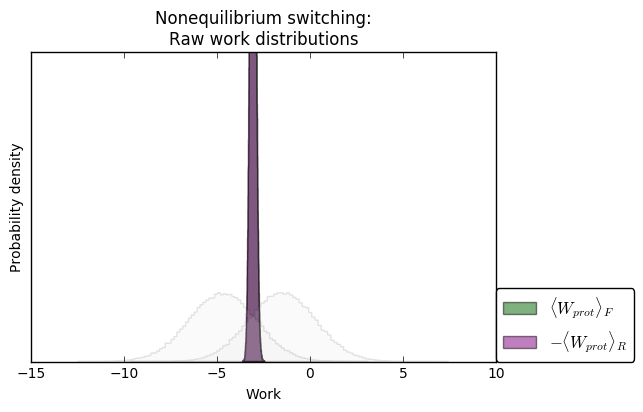

In [6]:
def plot_separately(result):

    # Plot the forward and reverse protocol work
    hist_args = {"bins": 100, "alpha": 0.5, "histtype": "stepfilled", "normed": True}
    hist_args["alpha"] = 0.1
    plt.hist(result.forward_raw, color="lightgrey", **hist_args);
    plt.hist(-result.reverse_raw, color="lightgrey", **hist_args);

    hist_args["alpha"] = 0.5
    # Plot the forward and reverse protocol work + shadow work
    plt.hist(result.forward_corrected, label=r"$\langle W_{prot} + W_{shad} \rangle_F$", color="blue", **hist_args);
    plt.hist(-result.reverse_corrected, label=r"$- \langle W_{prot} + W_{shad} \rangle_R$", color="red", **hist_args);

    # Format
    plt.legend(loc=(1,0), fancybox=True)
    plt.title("Nonequilibrium switching:\nCorrected work distributions")
    plt.xlabel("Work")
    plt.ylabel("Probability density")
    plt.yticks([])
    plt.ylim(0,1)
    
    plt.figure()
    # Plot the forward and reverse protocol work
    hist_args = {"bins": 100, "alpha": 0.5, "histtype": "stepfilled", "normed": True}
    hist_args["alpha"] = 0.5
    plt.hist(result.forward_raw, label=r"$\langle W_{prot} \rangle_F$", color="darkgreen", **hist_args);
    plt.hist(-result.reverse_raw, label=r"$- \langle W_{prot} \rangle_R$", color="purple", **hist_args);

    # Plot the forward and reverse protocol work + shadow work
    hist_args["alpha"] = 0.1
    plt.hist(result.forward_corrected, color="lightgrey", **hist_args);
    plt.hist(-result.reverse_corrected, color="lightgrey", **hist_args);

    # Format
    plt.legend(loc=(1,0), fancybox=True)
    plt.title("Nonequilibrium switching:\nRaw work distributions")
    plt.xlabel("Work")
    plt.ylabel("Probability density")
    plt.yticks([])
    plt.ylim(0,1)


plot_separately(results[0])
plot_separately(results[3])
plot_separately(results[-1])

In [8]:
def bootstrap_sample(samples, n_bootstrap_samples=100):
    """Draw n_bootstrap_samples with replacement from samples."""
    indices = np.random.randint(0, len(samples), n_bootstrap_samples)
    return samples[indices]

In [9]:
# plot estimate rmse as function of n_samples

n_sample_list = 10000 * np.linspace(0.01, 10, 10)

def get_estimates(result, n_replicates=10):
    raw_estimates = np.zeros((n_replicates, len(n_sample_list)))
    corrected_estimates = np.zeros((n_replicates, len(n_sample_list)))

    for i in tqdm(range(n_replicates)):
        for j, n_samples in enumerate(n_sample_list):

            # just protocol work
            f_bootstrap = bootstrap_sample(result.forward_raw, n_samples)
            r_bootstrap = bootstrap_sample(result.reverse_raw, n_samples)

            raw_estimate, _ = pymbar.bar.BAR(f_bootstrap, r_bootstrap)
            raw_estimates[i, j] = raw_estimate

            # protocol work + shadow work
            f_bootstrap = bootstrap_sample(result.forward_corrected, n_samples)
            r_bootstrap = bootstrap_sample(result.reverse_corrected, n_samples)

            corrected_estimate, _ = pymbar.bar.BAR(f_bootstrap, r_bootstrap)
            corrected_estimates[i, j] = corrected_estimate
    
    return raw_estimates, corrected_estimates

In [10]:
# Get the KL divergence ~exactly using numerical quadrature

@jit
def reduced_potential(x, lam):
    return potential(x, lam) * beta


@jit
def log_q(x, lam):
    return - reduced_potential(x, lam)


@jit
def q(x, lam):
    return np.exp(log_q(x, lam))


# normalized density
x_ = np.linspace(-10,10,10000)
Z_0 = np.trapz(q(x_, 0), x_)
log_Z_0 = np.log(Z_0)

Z_1 = np.trapz(q(x_, 1), x_)
log_Z_1 = np.log(Z_1)

def p0(x):
    return q(x, 0) / Z_0

def log_p0(x):
    return log_q(x, 0) - log_Z_0

def p1(x):
    return q(x, 1) / Z_1

def log_p1(x):
    return log_q(x, 1) - log_Z_1

exact_free_energy_difference = log_Z_0 - log_Z_1
exact_free_energy_difference

-3.0874619558305088

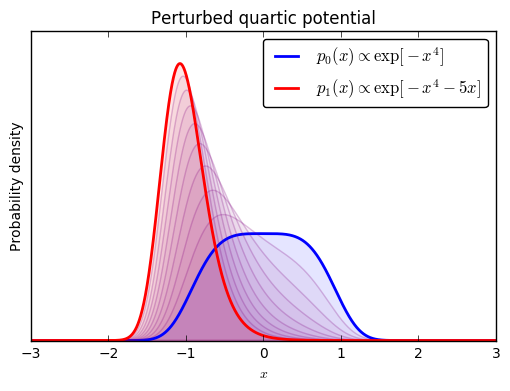

In [11]:
start_color = "blue"
middle_color = "purple"
end_color = "red"
linewidth=2

plt.plot(x_, p0(x_), label=r"$p_0(x) \propto \exp[- x^4 ]$", color=start_color, linewidth=linewidth)
plt.fill_between(x_, p0(x_), alpha=0.1, color=start_color)

for lam in np.linspace(0,1,10)[1:-1]:
    p_lam =  q(x_, lam) / np.trapz(q(x_, lam), x_)
    plt.plot(x_, p_lam, color=middle_color, alpha=0.2)
    plt.fill_between(x_, p_lam, alpha=0.05, color=middle_color)

plt.plot(x_, p1(x_), label=r"$p_1(x) \propto \exp[ - x^4 - 5x ]$", color=end_color, linewidth=linewidth)
plt.fill_between(x_, p1(x_), alpha=0.1, color=end_color)

plt.ylabel("Probability density")
plt.legend(loc="best", fancybox=True)
plt.yticks([])
plt.xlabel("$x$")
plt.xlim(-3,3)
plt.title("Perturbed quartic potential")

In [12]:
def plot_rmse(raw_estimates, corrected_estimates):

    plt.errorbar(n_sample_list,
                 np.sqrt(np.mean((raw_estimates - exact_free_energy_difference)**2, 0)),
                 np.std(np.abs(raw_estimates - exact_free_energy_difference), 0) / np.sqrt(len(raw_estimates)),
                 label="without shadow work")
    plt.errorbar(n_sample_list,
                 np.sqrt(np.mean((corrected_estimates - exact_free_energy_difference)**2, 0)),
                 np.std(np.abs(corrected_estimates - exact_free_energy_difference), 0) / np.sqrt(len(corrected_estimates)),
                 label="with shadow work")

    plt.ylabel("RMSE")
    plt.xlabel("# protocol samples")
    plt.legend(loc="best")
    plt.title("RMSE")

In [ ]:
estimates = []

for i in range(len(protocol_lengths)):
    raw_estimates, corrected_estimates = get_estimates(results[i], n_replicates=100)
    estimates.append((raw_estimates, corrected_estimates))

  0%|          | 0/100 [00:00<?, ?it/s]/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
 17%|█▋        | 17/100 [00:14<01:11,  1.16it/s]

In [ ]:
for i in range(len(protocol_lengths)):
    plt.figure()
    raw_estimates, corrected_estimates = estimates[i]
    plot_rmse(raw_estimates, corrected_estimates)
    plt.title("RMSE ({} switching steps)".format(protocol_lengths[i]))

In [ ]:
def plot_bias(raw_estimates, corrected_estimates):
    plt.plot(n_sample_list, np.mean(raw_estimates - exact_free_energy_difference, 0), label="without shadow work")
    plt.plot(n_sample_list, np.mean(corrected_estimates - exact_free_energy_difference, 0),label="with shadow work")

    plt.hlines(0, min(n_sample_list), max(n_sample_list))
    plt.ylabel("Estimate - actual")
    plt.xlabel("# protocol samples")
    plt.legend(loc="best")
    plt.title("Bias")

In [ ]:
for e in estimates:
    plt.figure()
    plot_bias(*e)